<a href="https://colab.research.google.com/github/AnuruddhaPaul/Neural-Network-from-scratch/blob/main/MiniGrad_NN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL NETWORK FROM SCRATCH
This notebook encompasses a comprehensive implementation of a Neural Network developed from scratch. The foundational concepts and techniques that underpin this implementation have been inspired by the PyTorch library, which is renowned for its flexibility and effectiveness in constructing deep learning models.

In this work, I have aimed to replicate key functionalities found in PyTorch while ensuring that the core principles of neural network architecture and training mechanisms are thoroughly understood and articulated. The implementation includes essential components such as forward propagation, backpropagation, activation functions, and optimization algorithms.

By delving into the specifics of each element, this notebook serves not only as a practical guide for building neural networks but also as an educational resource that illuminates the inner workings of these powerful computational models. It is my hope that readers will gain valuable insights and a deeper appreciation for the fundamentals of neural network design and implementation through this endeavor.

In [49]:
# basic imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def f(x):
  return 3*x**2-4*x+5

In [51]:
f(3)

20

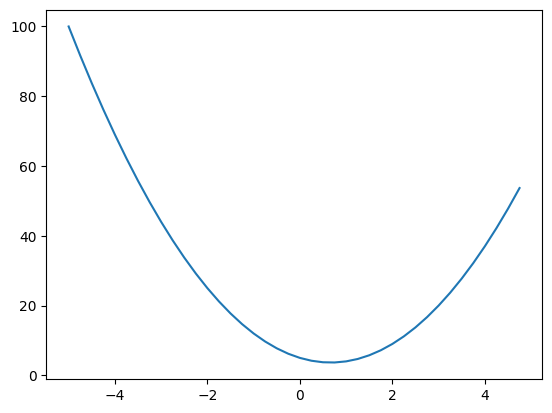

In [52]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

so what dose the derivative of a this function look like.

as  we know

L=$\lim_{h \to 0 } \frac{f(x+h)-f(x)}{h}$

If we nudge the function with h how will the function respond


In [53]:
h=0.0000001 #  very smalll h to converge
x=3.0
(f(x+h) -f(x))/h #slope of the derivative

14.000000305713911

In [54]:
h=0.0000001 #for the -3 the slop is -ve theat means we have to go down
x=-3.0
(f(x+h) -f(x))/h

-21.999999688659955

In [55]:
h=0.0000001
x=2/3
(f(x+h) -f(x))/h

2.9753977059954195e-07

In [56]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [57]:
# here we just bump the interested b=value with h
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [58]:
# here we just bump the interested b=value with h
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [59]:
# here we just bump the interested b=value with h
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# WHAT EVERY PART DO's IN THE NEXT CELL

***_chiledren*** tuple is used to store the relation what values effect or create other values

***_op*** is used to store the operation performent on it to produce this value

***label*** is used to store the lable

In [120]:
import math

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    # data: The actual scalar number (e.g., 2.0, -3.5) this node holds.
    self.data = data

    # grad: The gradient (derivative) of the final loss with respect to this value.
    # It represents how much changing this value will change the final output.
    # We initialize it to 0.0, meaning "no effect" until we calculate it.
    self.grad = 0.0

    # _backward: A function that stores the chain rule logic for this specific operation.
    # By default, for a leaf node (input number), it does nothing (lambda: None).
    # This will be replaced dynamically when we do operations like + or *.
    self._backward = lambda: None

    # _prev: A set containing the parent nodes (children in the graph sense) that produced this value.
    # This builds the computational graph DAG (Directed Acyclic Graph).
    # We use a set for efficiency to avoid duplicates.
    self._prev = set(_children)

    # _op: A string recording the operation that created this node (e.g., '+', '*', 'tanh').
    # Used mainly for debugging or visualization.
    self._op = _op

    # label: Optional string to name the variable (e.g., 'a', 'b', 'loss').
    self.label = label

  def __repr__(self):
    # Defines how the object looks when you print it.
    return f"Value(data={self.data})"

  # --- BASIC ARITHMETIC OPERATIONS ---

  def __add__(self, other):
    # This enables the syntax: a + b
    # Ensure 'other' is a Value object. If it's a raw number (e.g., a + 2), wrap it.
    other = other if isinstance(other, Value) else Value(other)

    # Create a new Value node for the result.
    # Its children are (self, other), and the op is '+'.
    out = Value(self.data + other.data, (self, other), '+')

    # Define the backward propagation for addition.
    # Local derivative of addition is 1.0.
    # Chain rule: self.grad += 1.0 * out.grad
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    # Attach this function to the output node so we can call it later.
    out._backward = _backward

    return out

  def __mul__(self, other):
    # This enables the syntax: a * b
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    # Define the backward propagation for multiplication.
    # Local derivative of (x * y) with respect to x is y.
    # Chain rule: self.grad += other.data * out.grad
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    # This enables the syntax: a ** b (power)
    # We assert other is int/float because we don't support Value**Value power yet.
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"

    out = Value(self.data**other, (self,), f'**{other}')

    # Backward for power rule: d/dx (x^n) = n * x^(n-1)
    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  # --- HELPER OPERATIONS (Syntactic Sugar) ---

  def __rmul__(self, other):
    # This enables the syntax: 2 * a (where 2 is not a Value object).
    # Python calls this when it fails to do `2.__mul__(a)`.
    # We simply swap it to `a * 2` which calls `__mul__`.
    return self * other

  def __truediv__(self, other):
    # This enables the syntax: a / b
    # We implement division as multiplication by power of -1: a * (b**-1)
    return self * other**-1

  def __neg__(self):
    # This enables the syntax: -a
    # Implemented as multiplication by -1.
    return self * -1

  def __sub__(self, other):
    # This enables the syntax: a - b
    # Implemented as addition of negative: a + (-b)
    return self + (-other)

  def __radd__(self, other):
    # This enables the syntax: 2 + a
    return self + other

  # --- ACTIVATION FUNCTIONS ---

  def tanh(self):
    # Hyperbolic tangent activation function.
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # Backward for tanh: d/dx tanh(x) = 1 - tanh(x)^2
    # Since t = tanh(x), the derivative is (1 - t**2).
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    # Exponential function: e^x
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    # Backward for exp: d/dx e^x = e^x
    # The output `out` itself holds e^x, so we use out.data.
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  # --- BACKPROPAGATION ENGINE ---

  """
  The backward() method orchestrates the entire backpropagation process.
  It needs to ensure that we calculate gradients in the correct order:
  from the output (loss) all the way back to the inputs.

  To do this, we use Topological Sort.
  """
  def backward(self):

    # 1. Build the topological graph
    topo = []
    visited = set()

    # Recursive helper function to traverse the graph
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        # Process all children (dependencies) before adding the current node
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    # Start the build from 'self' (usually the final loss node)
    build_topo(self)

    # 2. Initialize the gradient of the loss with respect to itself
    # dL/dL = 1.0. This kicks off the chain rule.
    self.grad = 1.0

    # 3. Apply the chain rule in reverse topological order
    # We go backwards through the 'topo' list (from output to inputs).
    # For every node, we call its stored `_backward()` function.
    for node in reversed(topo):
      node._backward()

In [61]:
a=Value(2.0)
b=Value(-3.0)
# a + b # python is calling like a.__add__(b)

a * b # python is calling like a.__mul__(b)

Value(data=-6.0)

In [62]:
a=Value(2.0)
b=Value(-3.0)
c=Value(10.0)

a*b+c #it is called like (a.__mul__(b)).__add__(c)

Value(data=4.0)

In [63]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [64]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

This is just the forward pass

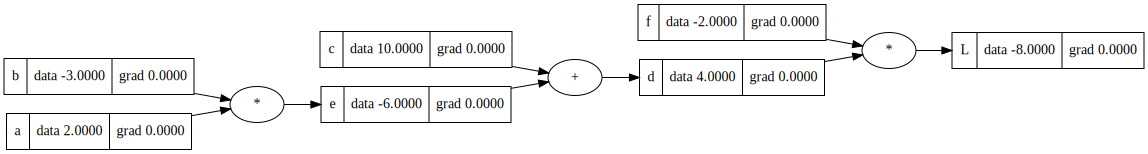

In [65]:
draw_dot(L)

Now we need to calculate the backward propagation

For L what will be the derivative
like what small amout of change in L will affect L as we know it will be proportional

In [66]:
def lol(): #not to disturebe the global scope it was created
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')

  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data+h

  print((L2 - L1)/h)

lol()

1.000000000000334


 # NOW for d and f
 L=d*f
 dL/dd=

 (f(x+h)-f(x))/h

 ((d+h)f*-d*f)/h

 (df+hf-df)/h

 f

 so for dL/df=d

In [67]:
def lol(): #not to disturebe the global scope it was created for d
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')

  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  d.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-2.000000000000668


 # NOW for e and c
 if we know what effect e or c has on d and same way what efect d have on L then we can find out this this intuitively

 using chain rule of derivative

 d=c+e

 so
dd/dc=dd/de=1.0

 *dd/dc=*

 (f(x+h)-f(x))/h

 ((c+h)+e-c-e)/h

 h/h

 1.0

 so $\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}$

In [68]:
def lol(): #not to disturebe the global scope it was created for d
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')

  c = Value(10.0, label='c')

  e = a*b; e.label = 'e'
  e.data+=h
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  e.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-2.000000000000668


#NOW for a and b

de/da=b ->know from above explanation
so

$\frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{da}$

$\frac{dL}{da} =$ -2.0

In [69]:
def lol(): #not to disturebe the global scope it was created for d
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data+=h
  c = Value(10.0, label='c')

  e = a*b; e.label = 'e'

  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  e.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


In [70]:
a.data += 0.01 * a.grad # we want to make the L go up
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


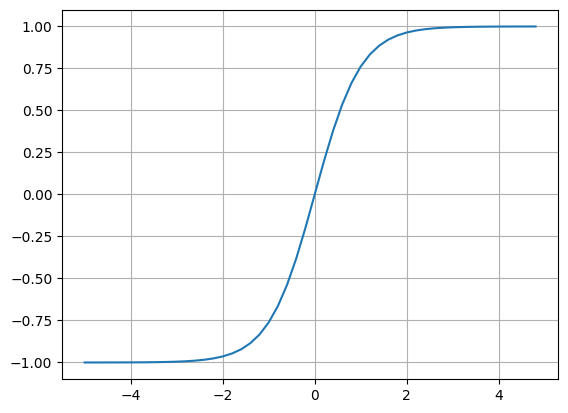

In [71]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [72]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' #This is the huperbolic function also known as activation function

So the derivative of tanh is

1 - $\tanh^2(x)$

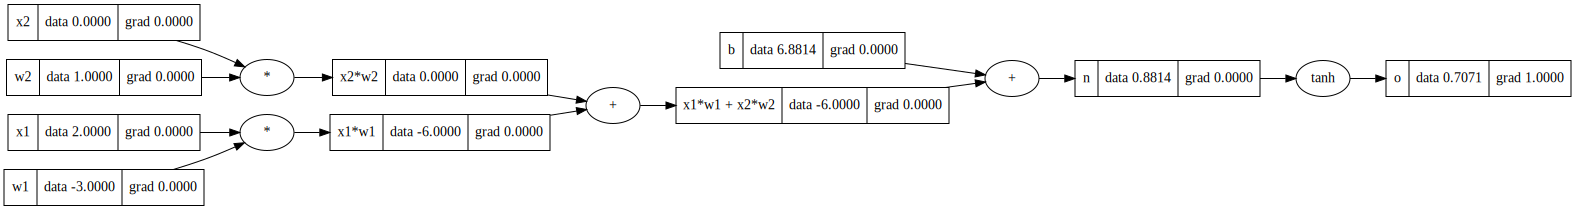

In [76]:
draw_dot(o)

In [75]:
# we need to init it
o.grad = 1.0

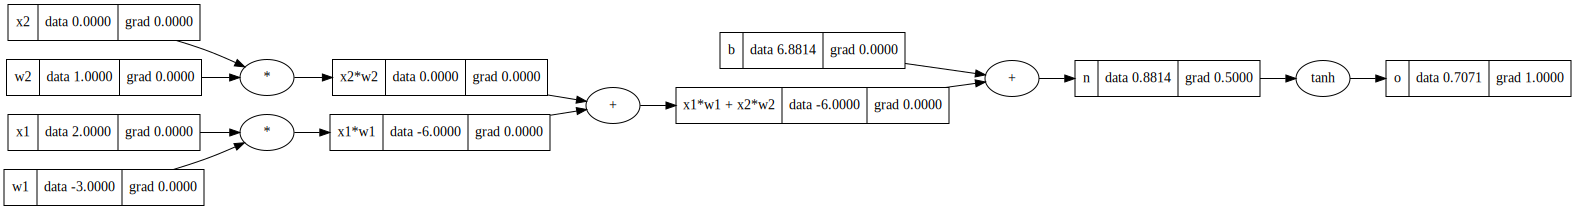

In [78]:
o._backward()
draw_dot(o)

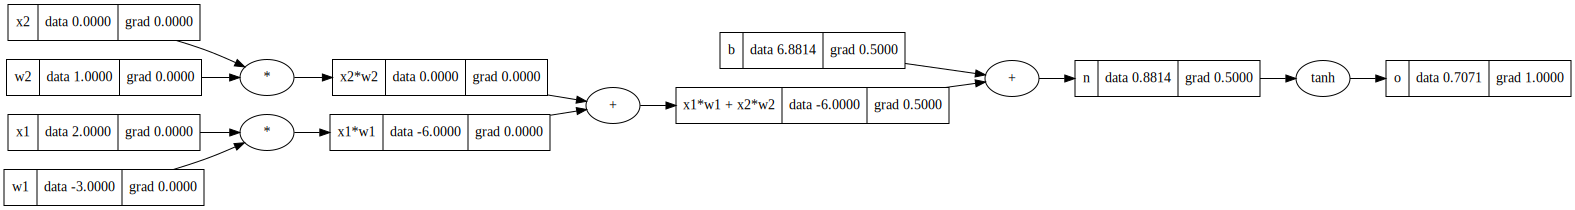

In [79]:
n._backward()
draw_dot(o)

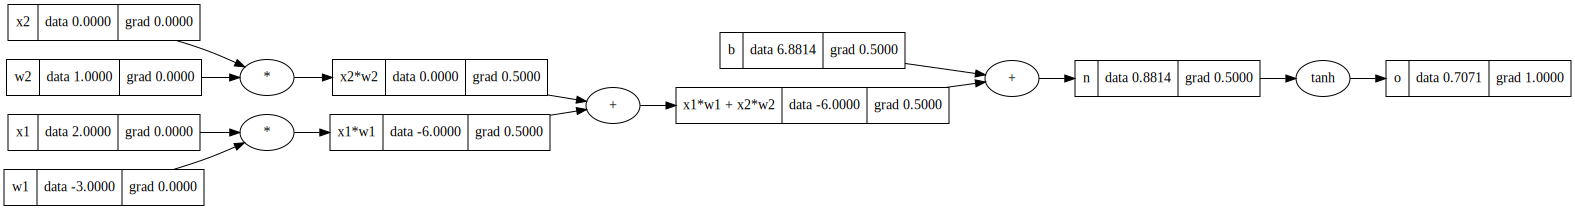

In [81]:
x1w1x2w2._backward()
draw_dot(o)

#NOW LETS TALK ABOUT A BUG THAT MAY SURFACE
take the below example the grad should be 2 but it is 1 as we are not accumulating the grad

if dont have unique values then this bug surfaces

\begin{}
def _backward():
    self.grad = 1.0 * out.grad
    other.grad = 1.0 * out.grad
out._backward = _backward
\end{}

as we are using the same variable so it jsut chanes the values not accumulate it

\begin{}
def _backward():
    self.grad += 1.0 * out.grad
    other.grad += 1.0 * out.grad
out._backward = _backward
\end{}

now it accumulate the gradien not just overwrite  as shoe by the chain rule

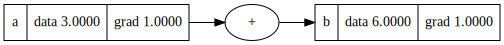

In [88]:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

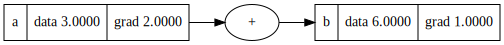

In [82]:

a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

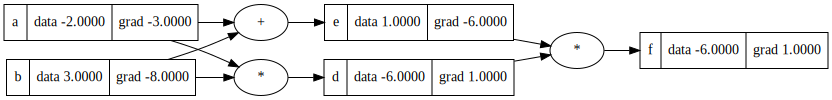

In [90]:

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [92]:
 x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

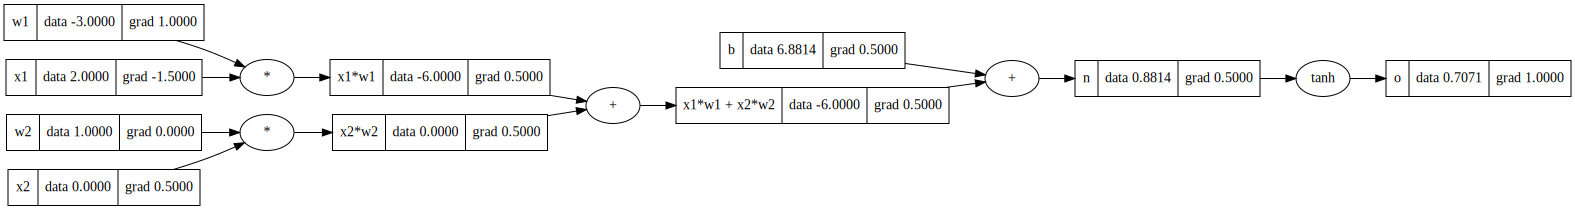

In [93]:

draw_dot(o)

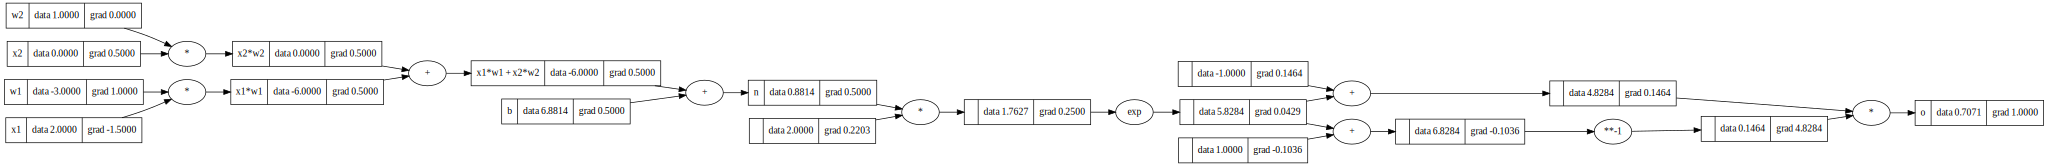

In [94]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [95]:
import torch

In [96]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # for inputs it is set to False
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [99]:
import random

In [100]:
class Neuron:

  def __init__(self, nin):
    # nin: Number of inputs coming into this neuron.
    # We create a list of weights 'w', one for each input.
    # Each weight is initialized to a random value between -1 and 1.
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]

    # We create a single bias 'b' for this neuron, also random between -1 and 1.
    # The bias allows the activation function to shift left or right.
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # This function defines the "forward pass" of the neuron.
    # x: The list of input values (e.g., from the previous layer or raw data).

    # zip(self.w, x): pairs each weight with its corresponding input
    # (e.g., [(w0, x0), (w1, x1), ...]).
    # (wi*xi for ...): This is a generator that calculates the product for each pair.
    # sum(..., self.b): Sums up all the products (dot product) and adds the bias 'self.b' at the end.
    # Mathematically: act = (w0*x0 + w1*x1 + ... + wn*xn) + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)

    # Apply the hyperbolic tangent (tanh) activation function to the sum.
    # This squashes the output to be between -1 and 1, introducing non-linearity.
    out = act.tanh()
    return out

  def parameters(self):
    # Returns a list of all trainable parameters in this neuron (weights + bias).
    # This is used later by the optimizer to update these values during backpropagation.
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    # nin: Number of inputs per neuron (size of the previous layer).
    # nout: Number of neurons in this current layer.
    # We create a list of 'nout' independent Neurons.
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    # We pass the input 'x' to every single neuron in this layer.
    # This produces a list of outputs, one from each neuron.
    outs = [n(x) for n in self.neurons]

    # If the layer has only 1 neuron, return the single value directly (not a list).
    # Otherwise, return the list of outputs to be used as inputs for the next layer.
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # Collects parameters from ALL neurons in this layer into a single flat list.
    # It iterates over every neuron, gets its params, and adds them to the list.
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    # nin: Integer, the number of inputs to the network.
    # nouts: List of integers, defining the size of all subsequent layers.
    # Example: if nin=3 and nouts=[4, 4, 1], then sz becomes [3, 4, 4, 1].
    sz = [nin] + nouts

    # We create the layers by iterating through the sizes.
    # i ranges from 0 to len(nouts).
    # Layer(sz[i], sz[i+1]) connects layer i to layer i+1.
    # e.g., Layer 1 takes 3 inputs, gives 4 outputs. Layer 2 takes 4 inputs, gives 4 outputs...
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    # This is the forward pass of the entire network.
    # It takes the initial input 'x' and passes it sequentially through each layer.
    for layer in self.layers:
        x = layer(x) # The output of one layer becomes the input 'x' for the next.
    return x # Returns the final output of the last layer.

  def parameters(self):
    # Collects parameters from ALL layers in the network into a single flat list.
    # This list represents every single weight and bias in the entire neural net.
    return [p for layer in self.layers for p in layer.parameters()]

In [101]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5272955661273436)

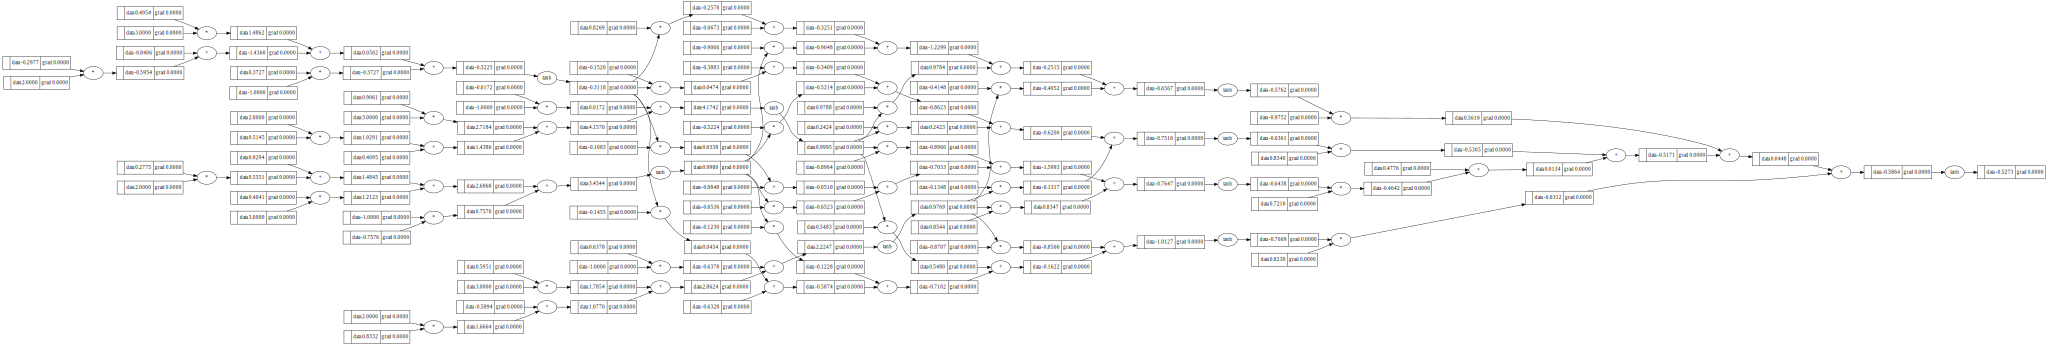

In [103]:
draw_dot(n(x))

In [104]:

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [119]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    """
    like in pythorch .zero_graad() we need to set the gradient to zero

    this is required because pytorch accumulates the gradients on subsequent backward passes.
    and if we don't flush the old one then it willl just keep on accumulate
    """
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.0007734171539894933
1 0.00076960987977647
2 0.0007658359478949217
3 0.0007620949580271637
4 0.0007583865158532206
5 0.0007547102329434572
6 0.0007510657266534135
7 0.0007474526200208902
8 0.000743870541665068
9 0.0007403191256878687
10 0.0007367980115772434
11 0.000733306844112493
12 0.0007298452732715486
13 0.0007264129541401596
14 0.00072300954682286
15 0.0007196347163558755
16 0.0007162881326216622
17 0.0007129694702652748
18 0.0007096784086123752
19 0.0007064146315888863
